### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
DENORM = pd.read_csv("denormalize_multipliers.csv")

def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='left').fillna(1)
    return df.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def target_encoding(df):
    enc = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        enc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
    df['target_mean_enc'] = enc
    return df

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        if len(seconds) > 1:
            gap = seconds[1]-seconds[2]
        else:
            gap = 0
        for i, second in enumerate(seconds):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d


def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

def denorm(df):
    global DENORM
    df = df.merge(DENORM, how="left")
    df['ask_price1'] *= df['multiplier']
    df['ask_price2'] *= df['multiplier']
    df['bid_price1'] *= df['multiplier']
    df['bid_price2'] *= df['multiplier']
    return df.drop(['multiplier'], axis=1)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"individual_book_train/stock_{stock_id}.csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(target_encoding(pd.concat(df, ignore_index = True)))

def generate_features(file_path):
    df = pd.read_csv(file_path)
    
    # denormalize prices
    df = denorm(df)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)
    
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'wap_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'ask_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        #'slope':[np.mean, np.std],#, mad, np.max, np.sum],
        #'dispersion':[np.mean, np.std],#, mad, np.max, np.sum],
        #'price_impact':[np.mean, np.std],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std],#, mad, np.max, np.sum],
        #'turn_over':[np.mean, np.std]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=300  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[300, 150],  # features generated for each second interval (different widths)
        overlap=1,
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

## Process Features for All Stocks

In [4]:
all_stocks = process_stocks(pd.read_csv("all_times.csv").stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.0min finished


,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bid_ask_spread1_std_100,bid_ask_spread2_mean_100,bid_ask_spread2_std_100,bid_ask_spread3_mean_100,bid_ask_spread3_std_100,ofi_mean_100,ofi_std_100,stock_id,target_mean_enc,beta
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,0.000185,0.001301,0.000169,0.062129,0.033834,15.50,79.718254,0,0.002943,1.208072
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,0.000089,0.000521,0.000098,0.037268,0.013813,0.33,15.101712,0,0.002974,1.719756
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,0.000173,0.001093,0.000264,0.092454,0.044815,-0.70,79.441675,0,0.002985,7.164047
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,0.000197,0.001232,0.000180,0.043375,0.023046,1.16,31.763240,0,0.002974,6.559597
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,0.000126,0.000517,0.000179,0.038508,0.013218,-1.08,54.879792,0,0.002974,0.680616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,0.000226,0.001261,0.000191,0.106065,0.059830,-0.29,115.410492,126,0.003887,0.895436
428928,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,0.000190,0.000889,0.000164,0.064115,0.042990,6.88,38.709558,126,0.003887,-1.346971
428929,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,0.000189,0.001175,0.000163,0.053480,0.011413,-1.03,39.823463,126,0.003904,0.904714
428930,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,0.000135,0.000860,0.000185,0.042486,0.017276,-0.84,111.050423,126,0.003904,-0.099107


In [5]:
len(all_stocks[all_stocks['target_realized_volatility']==0])

141

### Removing row with zero realized volatility
* Only one row where target_realized_vol = 0
* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

In [20]:
nozeros = all_stocks[all_stocks['target_realized_volatility'] != 0].reset_index(drop=True)
nozeros

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bid_ask_spread1_std_100,bid_ask_spread2_mean_100,bid_ask_spread2_std_100,bid_ask_spread3_mean_100,bid_ask_spread3_std_100,ofi_mean_100,ofi_std_100,stock_id,target_mean_enc,beta
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,0.000185,0.001301,0.000169,0.062129,0.033834,15.50,79.718254,0,0.002943,1.208072
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,0.000089,0.000521,0.000098,0.037268,0.013813,0.33,15.101712,0,0.002974,1.719756
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,0.000173,0.001093,0.000264,0.092454,0.044815,-0.70,79.441675,0,0.002985,7.164047
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,0.000197,0.001232,0.000180,0.043375,0.023046,1.16,31.763240,0,0.002974,6.559597
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,0.000126,0.000517,0.000179,0.038508,0.013218,-1.08,54.879792,0,0.002974,0.680616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,0.000226,0.001261,0.000191,0.106065,0.059830,-0.29,115.410492,126,0.003887,0.895436
428787,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,0.000190,0.000889,0.000164,0.064115,0.042990,6.88,38.709558,126,0.003887,-1.346971
428788,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,0.000189,0.001175,0.000163,0.053480,0.011413,-1.03,39.823463,126,0.003904,0.904714
428789,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,0.000135,0.000860,0.000185,0.042486,0.017276,-0.84,111.050423,126,0.003904,-0.099107


### Defining X for LightGBM

* should scale features if regularization?

In [26]:
all_stocks_X = nozeros.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
all_stocks_X[:] = MinMaxScaler().fit(all_stocks_X).transform(all_stocks_X)
all_stocks_X

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_std_300,log_returns2_realized_volatility_300,...,bid_ask_spread1_std_100,bid_ask_spread2_mean_100,bid_ask_spread2_std_100,bid_ask_spread3_mean_100,bid_ask_spread3_std_100,ofi_mean_100,ofi_std_100,stock_id,target_mean_enc,beta
0,0.051024,0.008230,0.051020,0.009313,0.044573,0.044573,2.147547e-06,0.560805,0.044544,0.046727,...,0.017960,0.041342,0.013304,0.007990,0.007332,0.503627,0.001394,0.0,0.357014,0.350452
1,0.052396,0.001546,0.052397,0.001718,0.008664,0.008664,1.008722e-08,0.547920,0.008662,0.013419,...,0.008648,0.014993,0.007744,0.004721,0.002993,0.502412,0.000264,0.0,0.362946,0.353272
2,0.054931,0.004633,0.054940,0.004655,0.025774,0.025774,5.085236e-07,0.549664,0.025772,0.033255,...,0.016807,0.034334,0.020831,0.011977,0.009712,0.502329,0.001390,0.0,0.364865,0.383277
3,0.056884,0.009135,0.056862,0.007817,0.024171,0.024171,7.369566e-07,0.534740,0.024139,0.022471,...,0.019095,0.039025,0.014238,0.005524,0.004994,0.502478,0.000556,0.0,0.362903,0.379946
4,0.056416,0.002549,0.056412,0.003401,0.014420,0.014420,1.686586e-07,0.541645,0.014412,0.022378,...,0.012194,0.014881,0.014133,0.004884,0.002864,0.502299,0.000960,0.0,0.362946,0.347545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,0.081197,0.008181,0.081213,0.009784,0.029778,0.029778,1.005541e-06,0.540214,0.029772,0.041803,...,0.021934,0.039982,0.015118,0.013767,0.012965,0.502362,0.002019,1.0,0.533707,0.348729
428787,0.077015,0.007352,0.077019,0.007810,0.028883,0.028883,4.504939e-07,0.553670,0.028872,0.033897,...,0.018406,0.027431,0.012908,0.008251,0.009316,0.502936,0.000677,1.0,0.533707,0.336371
428788,0.053304,0.003230,0.053301,0.003810,0.017821,0.017821,1.439967e-07,0.541082,0.017813,0.024924,...,0.018356,0.037084,0.012832,0.006852,0.002473,0.502303,0.000697,1.0,0.536811,0.348780
428789,0.039722,0.003412,0.039723,0.003561,0.036430,0.036430,9.313683e-07,0.559980,0.036399,0.040070,...,0.013042,0.026453,0.014595,0.005407,0.003744,0.502318,0.001943,1.0,0.536783,0.343248


### Defining y for LightGBM

In [27]:
all_stocks_y = nozeros[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

3830

In [28]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428786,0.002899,126,32751
428787,0.003454,126,32753
428788,0.002792,126,32758
428789,0.002379,126,32763


Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [29]:
EPSILON = 0 #1e-10 set epsilon to zero as removed zero row for realized volatility

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')
    
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), 4), False

### Nested 5-Fold Cross-Validation

In [42]:
%%time
test = pd.DataFrame({'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]})
all_models = []
split_importance = []
gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

# some params taken from research paper (link @ bottom of notebook)
params = {
    "objective": "regression",
    "metric": "rmse", 
    "boosting_type": "gbdt",
    "feature_fraction": 0.777,  
    "bagging_fraction": 0.888,
    "learning_rate": 0.01,
    "n_jobs": -1,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "force_col_wise": True,
  }


outer_kfold = KFold(n_splits=outer_k, random_state=0, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    inner_kfold = KFold(n_splits= inner_k, random_state=0, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
    
        lgbm_train = lgbm.Dataset(
            X_inner_train, 
            y_inner_train, 
            weight = 1 / (np.square(y_inner_train.values)+EPSILON)         # weighting rmspe
        )
        lgbm_valid = lgbm.Dataset(
            X_inner_valid, 
            y_inner_valid, 
            reference = lgbm_train, 
            weight = 1 / (np.square(y_inner_valid.values)+EPSILON)        # weighting rmspe
        )
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=5000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(50)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred)
        )
        
        print("\t"+"*" * 100)
        print(f'\tInner Validation RMSPE: {RMSPE}')
        print("\t"+"*" * 100)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test, num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 32752
[LightGBM] [Info] Number of data points in the train set: 274425, number of used features: 129
[LightGBM] [Info] Start training from score 0.001189
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000475634	training's RMSPE: 0.3242	valid_1's rmse: 0.000486227	valid_1's RMSPE: 0.3297
[200]	training's rmse: 0.000385683	training's RMSPE: 0.2629	valid_1's rmse: 0.000405228	valid_1's RMSPE: 0.2748
[300]	training's rmse: 0.000365839	training's RMSPE: 0.2494	valid_1's rmse: 0.00038933	valid_1's RMSPE: 0.264
[400]	training's rmse: 0.000358847	training's RMSPE: 0.2446	valid_1's rmse: 0.000384945	valid_1's

[900]	training's rmse: 0.000345034	training's RMSPE: 0.2354	valid_1's rmse: 0.000373891	valid_1's RMSPE: 0.2524
[1000]	training's rmse: 0.00034341	training's RMSPE: 0.2343	valid_1's rmse: 0.000373328	valid_1's RMSPE: 0.252
Early stopping, best iteration is:
[1048]	training's rmse: 0.000342675	training's RMSPE: 0.2338	valid_1's rmse: 0.000373135	valid_1's RMSPE: 0.2518
	****************************************************************************************************
	Inner Validation RMSPE: 0.25184482210600656
	****************************************************************************************************
************************************************************************************************************************
Outer Fold : 2
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 32752
[LightGBM] [Info] Nu

[500]	training's rmse: 0.000354185	training's RMSPE: 0.2415	valid_1's rmse: 0.000387234	valid_1's RMSPE: 0.2608
[600]	training's rmse: 0.000351148	training's RMSPE: 0.2395	valid_1's rmse: 0.000385192	valid_1's RMSPE: 0.2595
[700]	training's rmse: 0.000348708	training's RMSPE: 0.2378	valid_1's rmse: 0.000383992	valid_1's RMSPE: 0.2587
[800]	training's rmse: 0.000346664	training's RMSPE: 0.2364	valid_1's rmse: 0.000382796	valid_1's RMSPE: 0.2579
[900]	training's rmse: 0.000344915	training's RMSPE: 0.2352	valid_1's rmse: 0.00038201	valid_1's RMSPE: 0.2573
[1000]	training's rmse: 0.000343346	training's RMSPE: 0.2341	valid_1's rmse: 0.000381669	valid_1's RMSPE: 0.2571
Early stopping, best iteration is:
[954]	training's rmse: 0.000344028	training's RMSPE: 0.2346	valid_1's rmse: 0.000381741	valid_1's RMSPE: 0.2571
	****************************************************************************************************
	Inner Validation RMSPE: 0.2571475172678152
	**********************************

[LightGBM] [Info] Total Bins 32752
[LightGBM] [Info] Number of data points in the train set: 274427, number of used features: 129
[LightGBM] [Info] Start training from score 0.001187
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000476559	training's RMSPE: 0.3252	valid_1's rmse: 0.000477904	valid_1's RMSPE: 0.3227
[200]	training's rmse: 0.000386585	training's RMSPE: 0.2638	valid_1's rmse: 0.000391582	valid_1's RMSPE: 0.2644
[300]	training's rmse: 0.000366572	training's RMSPE: 0.2502	valid_1's rmse: 0.000374216	valid_1's RMSPE: 0.2527
[400]	training's rmse: 0.000359469	training's RMSPE: 0.2453	valid_1's rmse: 0.000369077	valid_1's RMSPE: 0.2492
[500]	training's rmse: 0.000355261	training's RMSPE: 0.2424	valid_1's rmse: 0.000366821	valid_1's RMSPE: 0.2477
[600]	training's rmse: 0.00035211	training's RMSPE: 0.2403	valid_1's rmse: 0.000365537	valid_1's RMSPE: 0.2468
[700]	training's rmse: 0.000349521	training's RMSPE: 0.2385	valid_1's rmse: 0.0003647

[900]	training's rmse: 0.000347753	training's RMSPE: 0.2352	valid_1's rmse: 0.000381068	valid_1's RMSPE: 0.2573
Early stopping, best iteration is:
[943]	training's rmse: 0.000347039	training's RMSPE: 0.2347	valid_1's rmse: 0.000380914	valid_1's RMSPE: 0.2572
	****************************************************************************************************
	Inner Validation RMSPE: 0.2572373337047576
	****************************************************************************************************

	********************
	*  Inner Fold : 5  *
	********************

[LightGBM] [Info] Total Bins 32752
[LightGBM] [Info] Number of data points in the train set: 274427, number of used features: 129
[LightGBM] [Info] Start training from score 0.001210
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000475275	training's RMSPE: 0.3212	valid_1's rmse: 0.000479718	valid_1's RMSPE: 0.3251
[200]	training's rmse: 0.00038782	training's RMSPE: 0.2621	valid_1's 

[300]	training's rmse: 0.000367095	training's RMSPE: 0.2502	valid_1's rmse: 0.000379908	valid_1's RMSPE: 0.2567
[400]	training's rmse: 0.000359788	training's RMSPE: 0.2452	valid_1's rmse: 0.000374844	valid_1's RMSPE: 0.2533
[500]	training's rmse: 0.000355514	training's RMSPE: 0.2423	valid_1's rmse: 0.000372601	valid_1's RMSPE: 0.2517
[600]	training's rmse: 0.000352272	training's RMSPE: 0.2401	valid_1's rmse: 0.000371296	valid_1's RMSPE: 0.2509
[700]	training's rmse: 0.000349661	training's RMSPE: 0.2383	valid_1's rmse: 0.000370337	valid_1's RMSPE: 0.2502
[800]	training's rmse: 0.000347446	training's RMSPE: 0.2368	valid_1's rmse: 0.000369697	valid_1's RMSPE: 0.2498
[900]	training's rmse: 0.00034557	training's RMSPE: 0.2355	valid_1's rmse: 0.000369208	valid_1's RMSPE: 0.2494
[1000]	training's rmse: 0.000343892	training's RMSPE: 0.2344	valid_1's rmse: 0.000368789	valid_1's RMSPE: 0.2492
[1100]	training's rmse: 0.000342361	training's RMSPE: 0.2333	valid_1's rmse: 0.000368456	valid_1's RMSPE

### Training Validation Result with 5-fold CV

In [43]:
print(f'Train Result RMSPE: {np.mean(train_scores)}')

Train Result RMSPE: 0.2579711397741174


In [44]:
train_scores

[0.26161363585047126,
 0.2578853927088428,
 0.2620445712884235,
 0.2526264982338246,
 0.2556856007890247]

## NOTE: Problem with using RMSPE when actual value near zero
* Solution: removed single row with zero realized vol

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [45]:
RMSPE = round(rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility']), 3)

print(f'Test Result RMSPE: {RMSPE}')

Test Result RMSPE: 0.26


## Mean Absolute Percentage Error

In [46]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10))) 

print(f"Test Result MAPE: {mape(test['target_realized_volatility'], test['predicted_volatility'])}")

Test Result MAPE: 0.18460143896577716


### Write Predictions to CSV

In [47]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("lightgbm_denorm_predict.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id
0,0.002254,0.001578,147,0
1,0.001726,0.001172,309,0
2,0.005394,0.005730,326,0
3,0.000980,0.001051,381,0
4,0.001738,0.001469,424,0
...,...,...,...,...
428786,0.012813,0.009808,32649,126
428787,0.002543,0.003245,32692,126
428788,0.001799,0.002421,32709,126
428789,0.004120,0.002672,32712,126


## Visualisation of Results

In [197]:
test['target_realized_volatility'].corr(test['predicted_volatility'])

0.9171078678488107

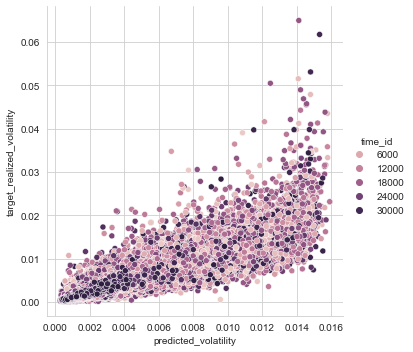

In [200]:
sns.relplot(
    data=test,
    x="predicted_volatility", y="target_realized_volatility",
    hue="time_id"
)

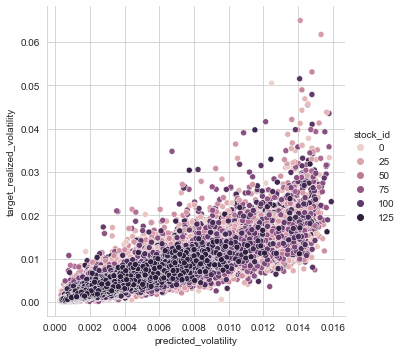

In [201]:
sns.relplot(
    data=test,
    x="predicted_volatility", y="target_realized_volatility",
    hue="stock_id"
)

In [147]:
def rmspe_test(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility'])
    
test_time = test.groupby('time_id').apply(rmspe_test).to_frame(name='RMSPE').reset_index()
test_stock = test.groupby('stock_id').apply(rmspe_test).to_frame(name='RMSPE').reset_index()

In [253]:
test_time.describe().transpose()[1:]

,count,mean,std,min,25%,50%,75%,max
RMSPE,3830.0,0.242647,0.09388,0.115435,0.203868,0.230231,0.26186,3.398333


In [244]:
test_stock.describe().transpose()[1:]

,count,mean,std,min,25%,50%,75%,max
RMSPE,112.0,0.247073,0.083125,0.154858,0.201079,0.230257,0.264927,0.846083


In [262]:
test_all = test.apply(rmspe_test, axis=1)

<AxesSubplot:>

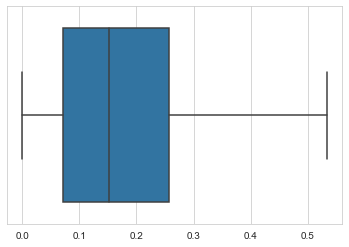

In [267]:
sns.boxplot(x=test_all, showfliers=False)

### By Time ID

<AxesSubplot:xlabel='RMSPE'>

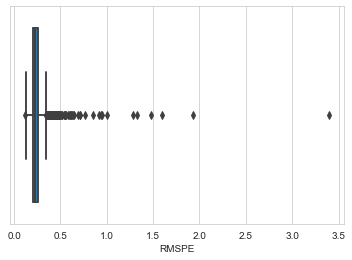

In [269]:
sns.boxplot(x=test_time["RMSPE"])

<AxesSubplot:xlabel='RMSPE'>

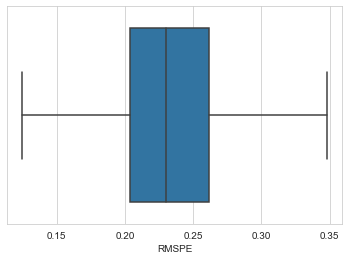

In [270]:
sns.boxplot(x=test_time["RMSPE"], showfliers=False)

In [137]:
test_time.iloc[test_time['RMSPE'].idxmax()]

time_id    29228.000000
RMSPE          3.398333
Name: 3445, dtype: float64

<Figure size 1080x576 with 0 Axes>

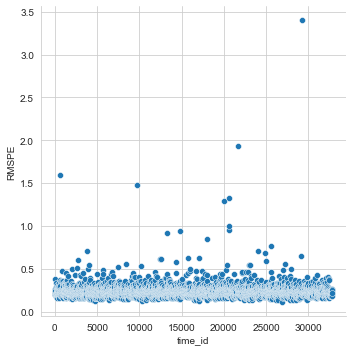

In [157]:
plt.figure(figsize=(15,8))
sns.relplot(y = 'RMSPE', x = 'time_id', data = test_time)
plt.show()

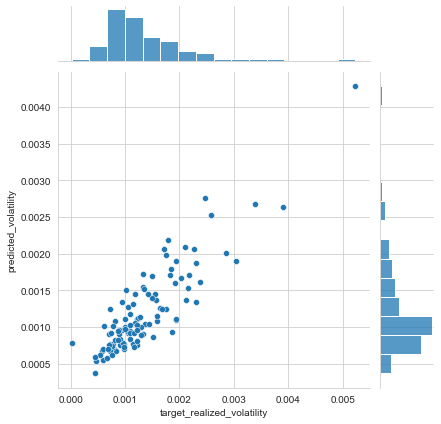

In [228]:
sub = test[test['time_id']==29228]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

In [229]:
test_time.iloc[test_time['RMSPE'].idxmin()]

time_id    26874.000000
RMSPE          0.115435
Name: 3201, dtype: float64

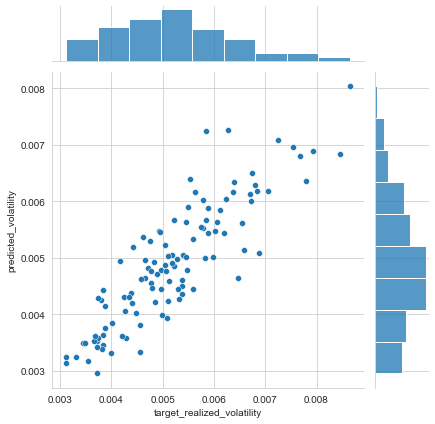

In [231]:
sub = test[test['time_id']==26874]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

### By Stock ID

In [215]:
test_stock.iloc[test_stock['RMSPE'].idxmax()]

stock_id    31.000000
RMSPE        0.846083
Name: 28, dtype: float64

<Figure size 1080x576 with 0 Axes>

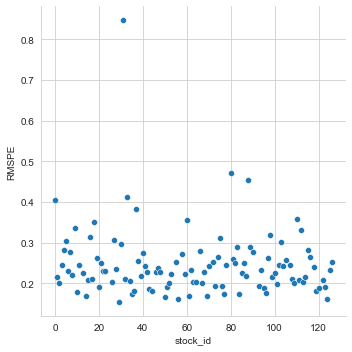

In [165]:
plt.figure(figsize=(15,8))
sns.relplot(y = 'RMSPE', x = 'stock_id',
            data = test_stock)
plt.show()

<AxesSubplot:xlabel='RMSPE'>

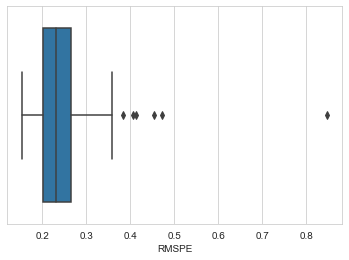

In [271]:
sns.boxplot(x=test_stock["RMSPE"])

<AxesSubplot:xlabel='RMSPE'>

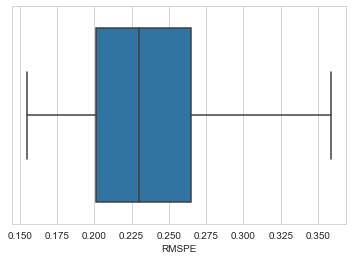

In [279]:
sns.boxplot(x=test_stock["RMSPE"], showfliers=False)

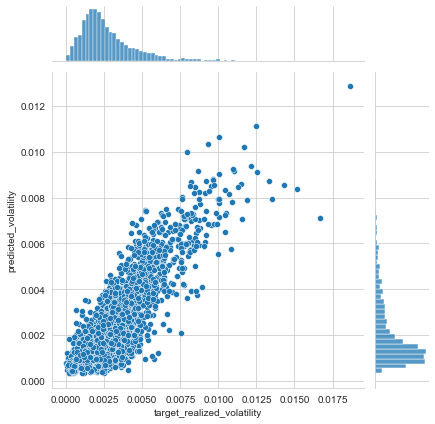

In [273]:
sub = test[test['stock_id']==31]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

In [274]:
test_stock.iloc[test_stock['RMSPE'].idxmin()]

stock_id    29.000000
RMSPE        0.154858
Name: 26, dtype: float64

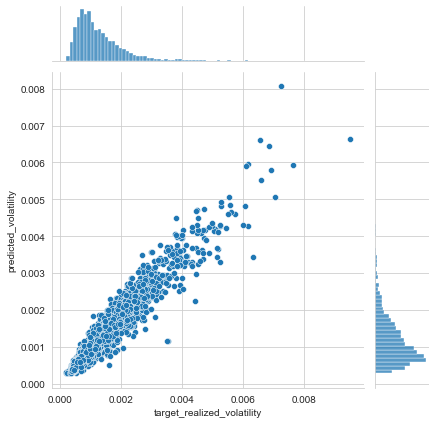

In [275]:
sub = test[test['stock_id']==29]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

In [288]:
test_stock[test_stock['stock_id']==31]

,stock_id,RMSPE
28,31,0.846083


## Model Feature Importance

In [48]:
import seaborn as sns

def plot_importance(importance, title='', save_to_file=None, top=None):    
    importance = importance.sort_values(
        ['Importance'], ascending=False
    )[:top]#.sort_values(['Importance'])
    
    plt.figure(figsize=(10, 8))
    #importance.plot.barh(ax=ax)
    sns.barplot(x="Importance", y="Features", data=importance.sort_values(by="Importance",ascending=False))
    
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(save_to_file)
    plt.show()
    plt.close()

def compute_mean_importance(importance):
    res = importance[0].copy()
    res['Importance'] = np.mean(np.array(
        [df['importance'].values for df in importance]
    ), axis=0)
    
    res = res.drop(['importance'], axis=1)
    
    # reformat for plot
    return pd.DataFrame(
        {'Features':[f for f in res.index], 
         'Importance': res['Importance']}
    ).reset_index(drop=True)


### Plotting Importance by Gain & Split

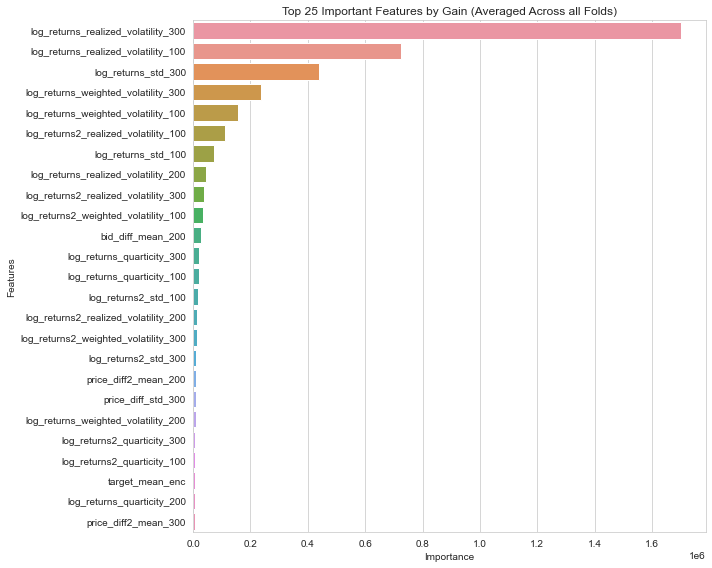

,Features,Importance
0,bid_ask_spread3_std_200,9.781328e+01
1,bid_ask_spread2_std_200,1.345579e+02
2,bid_ask_volume_diff_mean_100,1.533228e+02
3,dom_diff_mean_100,1.721764e+02
4,bid_ask_spread2_std_100,1.865727e+02
...,...,...
124,log_returns_weighted_volatility_100,1.554659e+05
125,log_returns_weighted_volatility_300,2.356171e+05
126,log_returns_std_300,4.398304e+05
127,log_returns_realized_volatility_100,7.257151e+05


In [291]:
mean_gain = compute_mean_importance(gain_importance)

plot_importance(mean_gain, title='Top 25 Important Features by Gain (Averaged Across all Folds)', top=25)

mean_gain

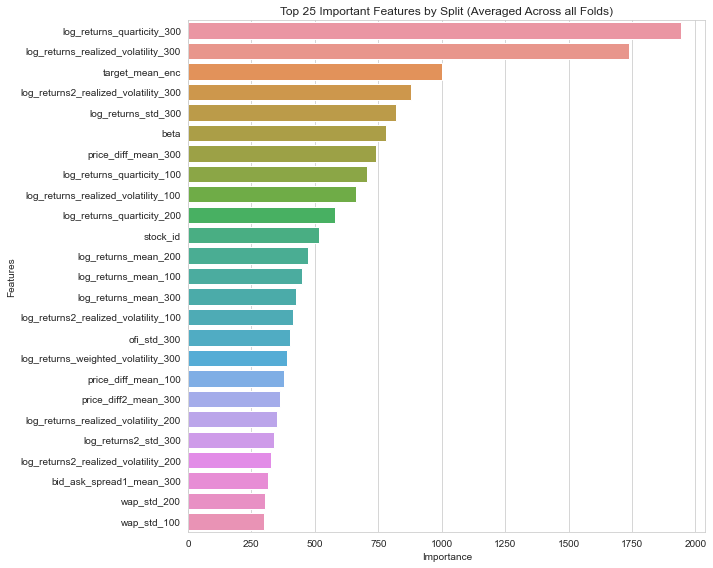

,Features,Importance
0,bid_ask_spread3_std_200,24.36
1,bid_ask_spread2_std_200,30.48
2,bid_ask_spread1_std_100,34.08
3,bid_ask_volume_diff_mean_100,37.32
4,wap2_mean_200,39.56
...,...,...
124,log_returns_std_300,818.28
125,log_returns2_realized_volatility_300,880.80
126,target_mean_enc,1001.04
127,log_returns_realized_volatility_300,1738.40


In [292]:
mean_split = compute_mean_importance(split_importance)
plot_importance(mean_split, title='Top 25 Important Features by Split (Averaged Across all Folds)', top=25)

mean_split

### Reference Paper: LightGBM Based Optiver Realized Volatility Prediction
#### Link:  https://ieeexplore-ieee-org.ezproxy.library.sydney.edu.au/document/9543438

### Notes to Self:

 Parameters:importance_type (string, optional (default="split")) – 
 
* If “split”, result contains numbers of times the feature is used in a model. 
 
* If “gain”, result contains total gains of splits which use the feature.
 
 Returns:   result – Array with feature importances.
 Return type:   numpy array`